# Bank Marketing Data - A Multilayer Perceptron (MLP) Approach

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

### Install and Load Libraries

In [1]:
#!pip install wandb

In [2]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from keras import callbacks
from keras.wrappers.scikit_learn import KerasClassifier

# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score
# imblearn

In [3]:
# Login to Weights & Biases
#!wandb login --relogin

In [4]:
#!python -c 'import keras; print(keras.__version__)'

# 1.0 Training



## 1.0.2 Holdout Configuration

In [3]:
# global variables

# ratio used to split train and validation data
val_size = 0.20
# seed used to reproduce purposes
seed = 41
# reference (column) to stratify the data
stratify = "y"
# name of the input artifact
artifact_input_name = "mlops_ivan/bank_mlp/train.csv:latest"
# type of the artifact
artifact_type = "Train"

In [4]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan", job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val0 = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

13-07-2022 21:10:11 Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: francisvalfgs (use `wandb login --relogin` to force relogin)


13-07-2022 21:10:19 Downloading and reading train artifact
13-07-2022 21:10:21 Spliting data into train/val


In [5]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val0.shape))

13-07-2022 21:10:21 x train: (25317, 16)
13-07-2022 21:10:21 y train: (25317,)
13-07-2022 21:10:21 x val: (6330, 16)
13-07-2022 21:10:21 y val: (6330,)


## 1.1 Data preparation

### 1.1.1 Outlier Removal

In [6]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("int64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

13-07-2022 21:10:25 Outlier Removal


In [7]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

13-07-2022 21:10:27 x_train shape [original]: (25317, 16)
13-07-2022 21:10:27 x_train shape [outlier removal]: (24746, 16)


In [8]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

### 1.1.2 Imbalanced Classification

Reference:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [9]:
df = pd.concat([x_train, y_train], axis=1)
df.y.value_counts()

no     21970
yes     2776
Name: y, dtype: int64

In [10]:
def resaple_bal(x_train, y_train):
  # random_state=0 , (sampling_strategy="auto")
  oversample = SMOTENC(categorical_features=[1, 2, 3, 4, 6, 7, 8, 10, 15],  sampling_strategy = 0.5)
  undersample = RandomUnderSampler(sampling_strategy="auto")
  X, y = oversample.fit_resample(x_train, y_train)
  X, y = undersample.fit_resample(X, y)
  return X, y


In [11]:
x_train_bal, y_train_bal = resaple_bal( x_train, y_train)

In [12]:
df_bal = pd.concat([x_train_bal, y_train_bal], axis=1)
df_bal.shape

(21970, 17)

In [13]:
df_bal.y.value_counts()

no     10985
yes    10985
Name: y, dtype: int64

### 1.1.3 Encoding Target Variable

In [14]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train_bal
y_train_bal = le.fit_transform(y_train_bal)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val0)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

13-07-2022 21:10:40 Encoding Target Variable
13-07-2022 21:10:40 Classes [0, 1]: ['no' 'yes']


## 1.2 Using a full-pipeline

#### 1.2.1 Feature Extractor

In [15]:
def copy_exception(feature_names, exceptions):
  # this functios return the itens in the feature_names except exceptions
  # if exceptions do not exist in feature_names it returns all feature_names
  # Imput: feature_names, exceptions: list
  # Output: list
  for exception in exceptions:
    try:
      feature_names.remove(exception)
    except ValueError:
      pass
    features_selected = feature_names
  return features_selected

In [18]:
f_sel = copy_exception(x_train_bal.select_dtypes("object").columns.to_list(), ["contact", "day"])
print(f_sel)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome']


In [17]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
      #exceptions = ["contact", "day", 'default', 'loan', 'marital']
      exceptions = ['default', 'loan']
      self.feature_names = copy_exception(feature_names, exceptions) 
      #self.feature_names = feature_names


    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:
            # df['job'] = df['job']
            # Combine similar jobs into categiroes
            df['job'] = df['job'].replace(['management', 'admin.'], 'white-collar')
            df['job'] = df['job'].replace(['services','housemaid'], 'pink-collar')
            df['job'] = df['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

            # minimize the cardinality poutcome
            df['poutcome'] = df['poutcome'].replace(['other'] , 'unknown')

            # Drop 'contact', as every participant has been contacted. 
            # df.drop('contact', axis=1, inplace=True)

            # day  : last contact day of the month
            # month: last contact month of year
            # Drop 'month' as they don't have any intrinsic meaning
            # df.drop('month', axis=1, inplace=True)
            df['month'] = df['month'].replace(['feb', 'mar', 'jan'], '1st')
            df['month'] = df['month'].replace(['may', 'jun', 'apr'], '2st')
            df['month'] = df['month'].replace(['jul', 'aug', 'sep'], '3st')
            df['month'] = df['month'].replace(['nov', 'oct', 'dec'], '4st')         

        # update column names
        self.colnames = df.columns

        return df
        
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # day  : last contact day of the month                  # adicionado
        # Drop 'day' as they don't have any intrinsic meaning
        # df.drop('day', axis=1, inplace=True)

        # Map padys=-1 into a large value (10000 is used) to indicate that it is so far in the past that it has no effect
        df.loc[df['pdays'] == -1, 'pdays'] = 10000

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [20]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train_bal)
df.head()

,job,marital,education,housing,contact,month,poutcome
0,management,single,tertiary,no,cellular,may,unknown
1,retired,single,tertiary,yes,unknown,nov,unknown
2,technician,married,unknown,no,unknown,jun,unknown
3,admin.,single,secondary,yes,unknown,jun,unknown
4,housemaid,married,primary,no,unknown,jun,unknown


In [21]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train_bal)
df.head()

,age,balance,day,duration,campaign,pdays,previous
0,24,3197,22,172,1,-1,0
1,51,730,18,287,2,-1,0
2,43,1156,16,90,2,-1,0
3,27,240,9,46,1,-1,0
4,43,522,5,86,1,-1,0


#### 1.2.2 Handling Categorical Features

In [22]:
x_train_bal.month.unique()

array(['may', 'nov', 'jun', 'aug', 'jul', 'jan', 'feb', 'apr', 'sep',
       'mar', 'oct', 'dec'], dtype=object)

In [23]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train_bal)
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,job,marital,education,housing,contact,month,poutcome
0,white-collar,single,tertiary,no,cellular,2st,unknown
1,other,single,tertiary,yes,unknown,4st,unknown
2,technician,married,unknown,no,unknown,2st,unknown
3,white-collar,single,secondary,yes,unknown,2st,unknown
4,pink-collar,married,primary,no,unknown,2st,unknown


In [24]:
# check the cardinality before and after transformation
x_train_bal.select_dtypes("object").apply(pd.Series.nunique)

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

In [25]:
# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

job          7
marital      3
education    4
housing      2
contact      3
month        4
poutcome     3
dtype: int64

#### 1.2.3 Handling Numerical Features

In [26]:
# for validation purposes
fs = FeatureSelector(x_train_bal.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train_bal)
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[-1.54247722e+00,  6.09543943e-01,  8.47376340e-01, ...,
        -5.40909467e-01,  1.00937443e+02, -3.76254967e-01],
       [ 9.34450526e-01, -2.69979229e-01,  3.38385248e-01, ...,
        -1.45271388e-01,  1.00937443e+02, -3.76254967e-01],
       [ 2.00546007e-01, -1.18103724e-01,  8.38897017e-02, ...,
        -1.45271388e-01,  1.00937443e+02, -3.76254967e-01],
       ...,
       [-4.41620447e-01, -1.33790396e-01,  5.92880794e-01, ...,
        -5.40909467e-01,  1.38057836e+00,  6.99178796e-01],
       [-9.00310771e-01, -2.19354061e-01,  4.65633021e-01, ...,
         6.46004771e-01,  1.00937443e+02, -3.76254967e-01],
       [-4.41620447e-01,  1.06410091e+00, -5.52349164e-01, ...,
        -1.45271388e-01,  8.02525870e-01,  1.61461915e-01]])

In [27]:
df_num.shape

(21970, 7)

In [28]:
# return columns name
nt.get_feature_names_out()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

#### 1.2.4 Data Preparation Pipeline

In [29]:
print(x_train_bal.select_dtypes("object").columns.to_list())

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [30]:
print(x_train_bal.select_dtypes("int64").columns.to_list())

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [19]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 2

# Categrical features to pass down the categorical pipeline
categorical_features = x_train_bal.select_dtypes("object").columns.to_list() 

# Numerical features to pass down the numerical pipeline
numerical_features = x_train_bal.select_dtypes("int64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       # ('cat_encoder','passthrough'
                                       ('cat_encoder', OneHotEncoder(sparse=False, drop="if_binary"))
                                       ]
                                ) # drop="first"

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                                           )

In [20]:
# for validation purposes
new_data = full_pipeline_preprocessing.fit_transform(x_train_bal)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df = pd.DataFrame(new_data,columns = cat_names + num_names)
df.head()

,job_blue-collar,job_entrepreneur,job_other,job_pink-collar,job_self-employed,job_technician,job_white-collar,marital_divorced,marital_married,marital_single,...,poutcome_failure,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,55.0,2923.0,29.0,94.0,1.0,259.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,39.0,2805.0,5.0,288.0,2.0,10000.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,35.0,498.0,21.0,248.0,1.0,10000.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,42.0,1336.0,22.0,65.0,1.0,10000.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,46.0,265.0,5.0,541.0,1.0,10000.0,0.0


In [33]:
print(df.columns.to_list())

['job_blue-collar', 'job_entrepreneur', 'job_other', 'job_pink-collar', 'job_self-employed', 'job_technician', 'job_white-collar', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'housing_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_1st', 'month_2st', 'month_3st', 'month_4st', 'poutcome_failure', 'poutcome_success', 'poutcome_unknown', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [34]:
print(new_data.shape)

(21970, 32)


## 1.5 Holdout Training

In this example the inference artifacts are:
- pipe (contains trained model and the preprocesing pipeline
- le (label encoder object used to encode the target variable)

In [21]:
def nn_model():	
  # define model
  model = Sequential()
  model.add(Dense(120, input_dim=32, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(60, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))

  # compile model
  opt =  'adam'
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

In [36]:
# The full pipeline 

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',   # 'loss'             
                min_delta=0.001, # Minimum change
                patience=50, # Number of epochs with no improvement
                verbose=1, # 
                mode='auto', # "auto", "min", "max"
                baseline=None, # Baseline value for the monitored quantity
                restore_best_weights=True) # restore weights epoch with best value

model = nn_model()

x_val_trans = full_pipeline_preprocessing.transform(x_val)

# training
logger.info("Training")
# fit model on train set
history = model.fit(new_data, y_train_bal,
                    epochs=100,
                    verbose=1,
                    #batch_size=512,
                    validation_data=(x_val_trans, y_val ),
                    callbacks=[early_stopping]
                    )


13-07-2022 20:50:23 Training


Epoch 1/100
687/687 [==============================] - 1s 920us/step - loss: 23.2331 - accuracy: 0.6848 - val_loss: 9.6678 - val_accuracy: 0.7880
Epoch 2/100
687/687 [==============================] - 1s 764us/step - loss: 12.8192 - accuracy: 0.7063 - val_loss: 11.6528 - val_accuracy: 0.6814
Epoch 3/100
687/687 [==============================] - 1s 775us/step - loss: 10.4260 - accuracy: 0.7149 - val_loss: 7.1763 - val_accuracy: 0.7603
Epoch 4/100
687/687 [==============================] - 1s 757us/step - loss: 10.1575 - accuracy: 0.7184 - val_loss: 2.0120 - val_accuracy: 0.8586
Epoch 5/100
687/687 [==============================] - 1s 802us/step - loss: 11.2951 - accuracy: 0.7198 - val_loss: 4.9587 - val_accuracy: 0.7897
Epoch 6/100
687/687 [==============================] - 1s 767us/step - loss: 8.8977 - accuracy: 0.7316 - val_loss: 8.6833 - val_accuracy: 0.6821
Epoch 7/100
687/687 [==============================] - 1s 759us/step - loss: 6.0941 - accuracy: 0.7490 - val_loss: 7.0860 - 



---



In [37]:
# predict
logger.info("Infering")
predict = model.predict(x_val_trans)

13-07-2022 20:51:17 Infering


198/198 [==============================] - 0s 452us/step


In [38]:
# Evaluation Metrics
y_pred = np.rint(predict)

logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, y_pred, beta=1, zero_division=1)
precision = precision_score(y_val, y_pred, zero_division=1)
recall = recall_score(y_val, y_pred, zero_division=1)
acc = accuracy_score(y_val, y_pred)
g_mean = geometric_mean_score(y_val, y_pred)


logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))
logger.info("G-Mean: {}".format(g_mean))

13-07-2022 20:51:17 Evaluation metrics
c:\Users\franc\.conda\envs\colab2deploy\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
13-07-2022 20:51:17 Accuracy: 0.7872037914691943
13-07-2022 20:51:17 Precision: 0.3372654155495979
13-07-2022 20:51:17 Recall: 0.85
13-07-2022 20:51:17 F1: 0.48291746641074856
13-07-2022 20:51:17 G-Mean: 0.8136690021627351


In [39]:
# evaluate model on test set
# _, test_acc = model.evaluate(test_x, test_y, verbose=0)

In [40]:
model.summary() # mostra modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               3960      
                                                                 
 dense_1 (Dense)             (None, 60)                7260      
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 11,281
Trainable params: 11,281
Non-trainable params: 0
_________________________________________________________________


In [41]:
clf.get_params().keys()

NameError: name 'clf' is not defined

In [ ]:
print(predict)

In [ ]:
dt6_score_train = pipe.score(x_train_bal, y_train_bal)
print("Training score: ",dt6_score_train)
dt6_score_test = pipe.score(x_val, y_val)
print("Testing score: ",dt6_score_test)

In [ ]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train_bal)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")
fbeta = fbeta_score(y_train_bal, predict_bias, beta=1, zero_division=1)
precision = precision_score(y_train_bal, predict_bias, zero_division=1)
recall = recall_score(y_train_bal, predict_bias, zero_division=1)
acc = accuracy_score(y_train_bal, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val,predict))

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["yes","no"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [ ]:
# Feature importance
pipe.get_params()["classifier"].feature_importances_

In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train_bal),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train_bal,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

In [ ]:
# Visualize single plot
# wandb.sklearn.plot_confusion_matrix(y_val, predict, [0,1])

In [ ]:
# Catch up the class proportions between train and validation
# wandb.sklearn.plot_class_proportions(y_train_bal, y_val, [0,1])

In [ ]:
# Plot the importance of columns
# wandb.sklearn.plot_feature_importances(pipe.get_params()["classifier"],all_names)

In [ ]:
# Plot a brief summary of the weighted avg results (recall, precision, f1, acc)
# wandb.sklearn.plot_summary_metrics(pipe.get_params()["classifier"],
#                                    full_pipeline_preprocessing.transform(x_train_bal),
#                                    y_train_bal,
#                                    full_pipeline_preprocessing.transform(x_val),
#                                    y_val)

In [ ]:
# ROC curve
# predict_proba = pipe.predict_proba(x_val)
# wandb.sklearn.plot_roc(y_val, predict_proba, [0,1])

In [ ]:
# close the current run before to execute the next section
run.finish()

## 1.6 Hyperparameter Tuning

In [ ]:
# To see all parameters of a specific step of the pipeline
# pipe.named_steps['classifier'].get_params() #or
# pipe.named_steps['full_pipeline'].get_params()

In [ ]:
# global seed
seed = 41

In [ ]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
        },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
            },
        "splitter": {
            "values": ["random","best"]
            },
        "max_depth": {
            "values": [5, 7, 9]
            },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="bank_mlp", entity="mlops_ivan")

In [ ]:
def train():
    with wandb.init() as run:

        # The full pipeline 
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                    ("classifier",DecisionTreeClassifier())
                                    ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__max_depth": run.config.max_depth})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train_bal, y_train_bal)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [ ]:
wandb.agent(sweep_id, train, count=24)

## 1.7 Configure and train the best model

In [ ]:
# Note that a new run is yet synced to last sweep run
# Just to check
# run = wandb.init()

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```1.4.3```, ```1.4.4```, ```1.5``` and ```1.6```. 

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="train")

In [ ]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
# pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 1})
# pipe.set_params(**{"classifier__criterion": 'entropy'})
# pipe.set_params(**{"classifier__splitter": 'random'})
# pipe.set_params(**{"classifier__max_depth": 6})
# pipe.set_params(**{"classifier__random_state": 41})

pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})
pipe.set_params(**{"classifier__criterion": 'gini'})
pipe.set_params(**{"classifier__splitter": 'best'})
pipe.set_params(**{"classifier__max_depth": 6})
pipe.set_params(**{"classifier__class_weight": {0:1.0, 1:6.0}})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train_bal, y_train_bal)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train_bal),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train_bal,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

## 1.8 Export the best model

In [ ]:
model.evaluate(testX, testY_one_hot)[1]

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')

In [42]:
# pipe = Pipeline(steps =  [
#                          ('full_pipeline', full_pipeline_preprocessing),
#                          ("classifier", model)
#                          ])

In [22]:
pipe = full_pipeline_preprocessing

In [23]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"
artifact_keras_model = "keras_model_export"

In [24]:
logger.info("Dumping the artifacts to disk")
# Save the pipiline preprocessing using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

13-07-2022 21:12:01 Dumping the artifacts to disk


['target_encoder']

In [25]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and MLP bank marketing model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

13-07-2022 21:12:08 Logging model artifact


In [26]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

13-07-2022 21:12:10 Logging target enconder artifact


In [27]:
run.finish()

In [ ]:
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="save")

In [ ]:
model.save(os.path.join(wandb.run.dir, "model.h5"))

In [ ]:
run.finish()

In [ ]:
import tensorflow as tf

best_model = wandb.restore('model.h5', run_path="mlops_ivan/bank_mlp/akrq1ozh")
# restore the model for tf.keras
model = tf.keras.models.load_model(best_model.name)

In [ ]:
pred = model.predict(x_val_trans)

198/198 [==============================] - 0s 462us/step


In [ ]:
pred

array([[0.70484084],
       [0.00385728],
       [0.30714557],
       ...,
       [0.06461261],
       [0.44749427],
       [0.60181695]], dtype=float32)

In [ ]:
y_pred = np.rint(pred)


In [ ]:
y_pred

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

# 2.0 Test evaluation

## 2.1 Evaluation

In [ ]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "mlops_ivan/bank_mlp/test.csv:latest"

# name of the model artifact
artifact_model_name =  "mlops_ivan/bank_mlp/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name =  "mlops_ivan/bank_mlp/target_encoder:latest"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="test")

wandb: Currently logged in as: francisvalfgs (mlops_ivan). Use `wandb login --relogin` to force relogin


In [ ]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("y")

02-06-2022 13:29:40 Downloading and reading test artifact
02-06-2022 13:29:41 Extracting target from dataframe


In [ ]:
# Takes a look at test set
x_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,31,entrepreneur,single,tertiary,no,206,no,no,cellular,15,jun,88,2,-1,0,unknown
1,31,management,single,tertiary,no,499,yes,no,unknown,9,jun,122,2,-1,0,unknown
2,44,technician,married,tertiary,no,4580,yes,no,cellular,20,nov,192,2,189,2,success
3,49,management,married,tertiary,no,176,yes,yes,cellular,14,jul,102,2,-1,0,unknown
4,28,blue-collar,single,primary,no,442,no,no,cellular,30,jan,157,2,-1,0,unknown


In [ ]:
# Take a look at the target variable
y_test.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

In [ ]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

02-06-2022 13:29:41 Extracting the encoding of the target variable


In [ ]:
# transform y_train
y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

02-06-2022 13:29:42 Classes [0, 1]: ['no' 'yes']


In [ ]:
# target variable after the encoding
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

02-06-2022 13:29:50 Downloading and load the exported model


In [ ]:
# predict
logger.info("Infering")
predict = pipe.predict(x_test)

# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1)
precision = precision_score(y_test, predict, zero_division=1)
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

02-06-2022 13:29:53 Infering
02-06-2022 13:29:53 Test Evaluation metrics
02-06-2022 13:29:53 Test Accuracy: 0.8961220878796815
02-06-2022 13:29:53 Test Precision: 0.6578014184397163
02-06-2022 13:29:53 Test Recall: 0.23377441713925645
02-06-2022 13:29:53 Test F1: 0.3449558344955834


In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11977
           1       0.66      0.23      0.34      1587

    accuracy                           0.90     13564
   macro avg       0.78      0.61      0.64     13564
weighted avg       0.88      0.90      0.87     13564



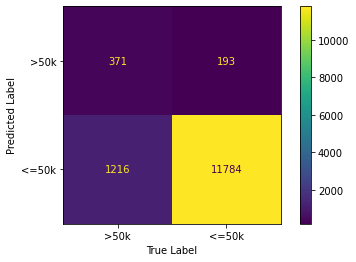

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=[">50k","<=50k"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

02-06-2022 13:30:02 Uploading figures


In [ ]:
run.finish()

Acc,0.89612
F1,0.34496
Precision,0.6578
Recall,0.23377
